In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data, pileup_data, muon_data_split, pileup_data_split,
                     mix_training_inputs)

from nn_models import (create_model, create_model_bn, create_model_pruned, create_model_mdn,
                       create_model_sequential, create_model_sequential_regularized,
                       lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.19.2


In [2]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.301)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.17.npz ...
[INFO    ] Loaded the variables with shape (3275752, 87)
[INFO    ] Loaded the parameters with shape (3275752, 3)
[INFO    ] Loaded # of training and testing events: (2289750, 986002)


In [3]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=30)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd.17.npz ...
[INFO    ] Loaded the variables with shape (332528, 87)
[INFO    ] Loaded the auxiliary PU info with shape (332528, 4)
[INFO    ] Loaded # of training and testing events: (160284, 172244)


In [4]:
# Create models
# model_seq is a densely connected NN with 3 hidden layers and 1 output node
# model is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

model_seq = create_model_sequential(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg)

#model_seq = create_model_sequential_regularized(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg)

model = create_model(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                     nodes1=48, nodes2=32, nodes3=20)

#model = create_model_bn(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
#                        nodes1=48, nodes2=32, nodes3=20)

### Training

In [5]:
# Hello, what do you want to train today?

training_seq = False
training_func = False
training_pruned = False
training_mdn = True

In [6]:
# Training (Sequential)

if training_seq:
  assert(keras.backend.backend() == 'tensorflow')

  history = train_model(model_seq, x_train, y_train[0] if isinstance(y_train, list) else y_train, 
                        model_name='model', epochs=200, batch_size=256,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [7]:
# Training (Functional)

if training_func:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut)
  else:
    raise Exception('add_noise must be set to True')

  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=300, batch_size=256,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [8]:
# Training (with Pruning)
# 1. First training: do the same thing as 'Training (Functional)', but with l1_reg and large batch_size.
# 2. Apply pruning
# 3. Retraining with pruned model, repeat the same thing as 'Training (Functional)'

if training_pruned:
  assert(keras.backend.backend() == 'tensorflow')
  
  # First training
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut)
  else:
    raise Exception('add_noise must be set to True')
  
  l1_reg = 1e-4
  model = create_model(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                       nodes1=48, nodes2=32, nodes3=20)
  
  logger.info('Training model with l1_reg: {0}'.format(l1_reg))
  
  small_epochs = 30
  large_batch_size = 2048
  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=small_epochs, batch_size=large_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [9]:
if training_pruned:
  # Apply pruning
  from nn_models import clone_model
  model_unpruned = clone_model(model)  # deep copy
  model_unpruned.set_weights(model.get_weights())

  pruning_percentile = 40.
  pruned = prune_model(model, percentile=pruning_percentile)
  (weightsPerLayer, droppedPerLayer, binaryTensorPerLayer, allWeightsByLayer, allWeightsArray) = pruned

In [10]:
if training_pruned:
  # Check pruning
  percentiles = [5.,pruning_percentile,95.]
  colors = ['r','g','r']
  vlines = np.percentile(allWeightsArray,percentiles,axis=-1)

  #xmin = np.min(allWeightsArray[np.nonzero(allWeightsArray)])
  #xmax = np.max(allWeightsArray)
  xmin = 1e-7
  xmax = 1
  bins = np.linspace(xmin, xmax, 50)
  logbins = np.geomspace(xmin, xmax, 50)

  #plt.figure()
  #plt.hist(allWeightsByLayer.values(),bins=bins,histtype='bar',stacked=True,label=allWeightsByLayer.keys())
  #plt.legend(prop={'size':10}, loc='upper right')
  #axis = plt.gca()
  #ymin, ymax = axis.get_ylim()
  #for vline, percentile, color in zip(vlines, percentiles, colors):
  #  if percentile==0: continue
  #  if vline < xmin: continue
  #  plt.axvline(vline, 0, 1, color=color, linestyle='dashed', linewidth=1, label='%s%%'%percentile)
  #  plt.text(vline, ymax+0.01*(ymax-ymin), '%s%%'%percentile, color=color, horizontalalignment='center')
  #plt.ylabel('Number of Weights')
  #plt.xlabel('Absolute Relative Weights')
  #plt.show()

  plt.figure()
  plt.hist(allWeightsByLayer.values(),bins=logbins,histtype='bar',stacked=True,label=allWeightsByLayer.keys())
  plt.legend(prop={'size':10}, loc='upper left')
  plt.semilogx()
  axis = plt.gca()
  ymin, ymax = axis.get_ylim()
  for vline, percentile, color in zip(vlines, percentiles, colors):
    if percentile==0: continue
    if vline < xmin: continue
    plt.axvline(vline, 0, 1, color=color, linestyle='dashed', linewidth=1, label='%s%%'%percentile)
    plt.text(vline, ymax+0.01*(ymax-ymin), '%s%%'%percentile, color=color, horizontalalignment='center')
  plt.ylabel('Number of Weights')
  plt.xlabel('Absolute Relative Weights')
  plt.show()

In [11]:
if training_pruned:
  # Retraining with pruned_model
  from nn_models import ZeroSomeWeights as zero_some_weights
  constraints = []
  for layer in model_unpruned.layers:
    if layer.name.startswith('dense_'):
      binary_tensor = binaryTensorPerLayer[layer.name]
      logger.info('Found binary tensor {0} with shape {1}'.format(layer.name, binary_tensor.shape))
      constraint = zero_some_weights(binary_tensor)
      constraints.append(constraint)
  constraint1, constraint2, constraint3 = constraints  # len() must be equal to 3
  
  l1_reg = 0.0
  model = create_model_pruned(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                              nodes1=48, nodes2=32, nodes3=20, constraint1=constraint1, constraint2=constraint2, constraint3=constraint3)
  
  logger.info('Retraining model with constraints.')
  
  normal_epochs = 200
  normal_batch_size = 256
  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=normal_epochs, batch_size=normal_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [12]:
if training_mdn:
  assert(keras.backend.backend() == 'tensorflow')
  
  model = create_model_mdn(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                           nodes1=48, nodes2=32, nodes3=0, mixture=mixture)
  
  history = train_model(model, x_train, y_train[0] if isinstance(y_train, list) else y_train, 
                        model_name='model', epochs=10, batch_size=256,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Begin training ...
[INFO    ] Done training. Time elapsed: 0:06:56.444659 sec
[INFO    ] Epoch 10/10 - loss: 2.38296766006 - val_loss 2.33423898961


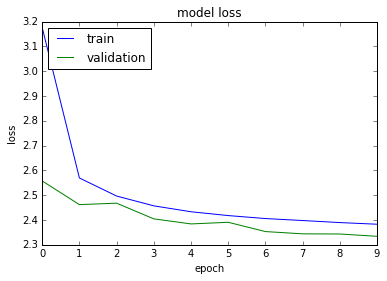

In [13]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=2048)

if training_seq or training_func or training_pruned or training_mdn:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [14]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')
eps = 1e-4
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

# Setup Gaussian fit
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
  return 0.5*a*np.exp(-np.square((x-x0)/sigma))

def fit_gaus(hist, edges, mu=0., sig=1.):
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  return popt

In [15]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
loaded_model = load_my_model(name='model', weights_name='model_weights')

nentries_test = x_test.shape[0]//4

predict_mdn = True

def predict(x):
  y = loaded_model.predict(x, batch_size=2048)
  if predict_mdn:
    y = (y[:, mixture*0:mixture*1] * y[:, mixture*1:mixture*2]).sum(axis=1, keepdims=True)
  return y

# Prepare x_test_ndof
x_test_ndof = (x_mask_test[:nentries_test] == False).sum(axis=1)
#print x_test_ndof.shape, x_test_ndof

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = predict(x_test[:nentries_test])
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] # of entries: 246500, mean: -0.00168646627571, std: 0.0337277948856
[INFO    ] gaus fit (a, mu, sig): [ 5.05896967e+04 -1.52616704e-03  2.93528648e-02]


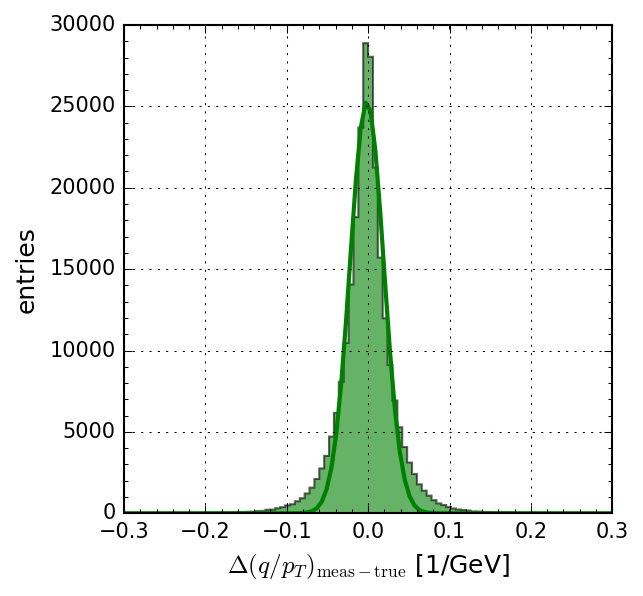

In [16]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

[INFO    ] # of entries: 246500, mean: 0.12182714045, std: 0.213455662131
[INFO    ] gaus fit (a, mu, sig): [ 5.94506676e+04 -4.25926681e-03  1.69965367e-01]


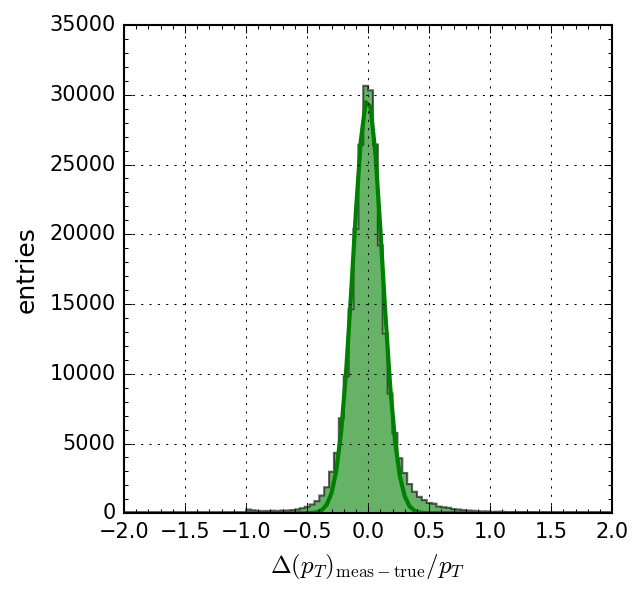

In [17]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


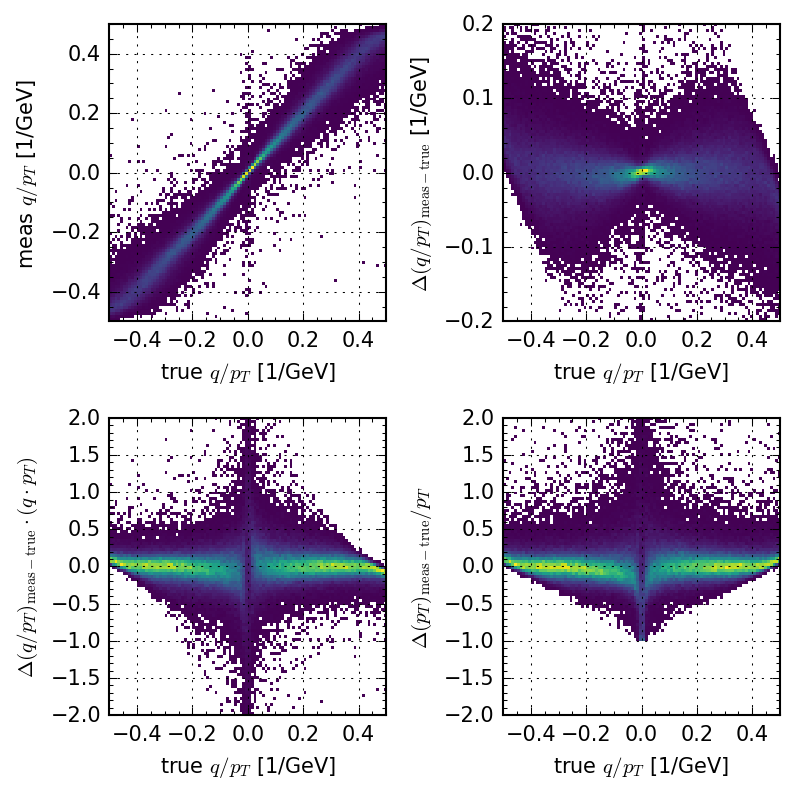

In [18]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [19]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[np.abs(yy_i) < 2]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 4.48612343e+02 -5.92877357e-02  2.56095289e-01]


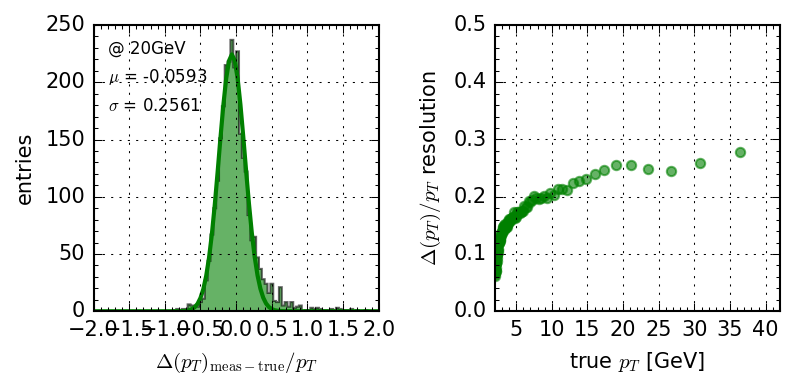

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=np.mean(yy_20GeV), sig=np.std(yy_20GeV[np.abs(yy_20GeV)<1.5]))
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(2,42)
axs[1].set_ylim(0,0.5)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)

plt.show()

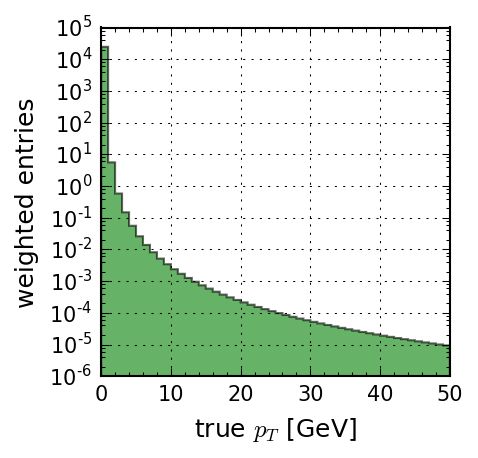

In [21]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [22]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 15.060303688 rate 147.397262573
[INFO    ] 22 GeV threshold 16.7260398865 rate 112.342758179


In [23]:
# Use the predicted rate as loss function/scoring in training
if False:
  from nn_models import NewKerasRegressor
  estimator = NewKerasRegressor(build_fn=create_model_sequential, reg_pt_scale=reg_pt_scale, min_pt=20., max_pt=22., coverage=90.,
                                nvariables=nvariables, lr=learning_rate)

  estimator.model = loaded_model

  # Cross check
  print estimator.score2(x_test[:nentries_test], y_test[0][:nentries_test] if isinstance(y_test, list) else y_test)

### Mixture Density Network

In [43]:
mdn_results = loaded_model.predict(x_test[:nentries_test], batch_size=2048)
pi     = mdn_results[:,mixture*0:mixture*1]
mus    = mdn_results[:,mixture*1:mixture*2]
sigmas = mdn_results[:,mixture*2:mixture*3]

pred_weights, pred_means, pred_std = pi, mus, sigmas
print(pred_weights.shape, pred_means.shape, pred_std.shape)
for i in range(10):
  #print(pred_weights[i], pred_means[i], pred_std[i])
  tmp = pred_weights[i].argsort()[::-1]
  pred_weights[i] = pred_weights[i][tmp]
  pred_means[i]   = pred_means[i][tmp]
  pred_std[i]     = pred_std[i][tmp]
  #print(pred_weights[i], pred_means[i], pred_std[i])
  mu = np.sum(pred_weights[i] * pred_means[i])
  std = np.sum(pred_weights[i] * (np.square(pred_std[i]) + np.square(pred_means[i] - mu)))
  std = np.sqrt(std)
  print(y_test[0][i], np.sum(pred_weights[i]), mu, std, np.abs(reg_pt_scale/y_test[0][i]), np.abs(reg_pt_scale/mu))

((246500, 6), (246500, 6), (246500, 6))
(-10.332808, 0.9999999, -3.64091, 2.6565166, 9.677911797373152, 27.465661734665446)
(-37.23177, 1.0, -36.644913, 3.247651, 2.6858782479865697, 2.7288917499909435)
(-5.7431827, 1.0000001, -6.443, 1.3979315, 17.41194838034537, 15.52072054736733)
(-28.497913, 1.0, -29.780085, 5.381318, 3.5090288448371387, 3.3579488208193236)
(12.855644, 1.0000001, 12.0831, 2.1042812, 7.77868446274959, 8.276021663373204)
(17.373402, 1.0, 16.07786, 2.832538, 5.755925181579827, 6.219733270189476)
(-32.289124, 1.0, -23.635117, 3.1238816, 3.0970180993336798, 4.230992458767256)
(48.169193, 1.0, 42.86364, 3.6578763, 2.076015669268048, 2.3329796627866144)
(-18.238745, 1.0, -18.16507, 2.3945475, 5.482833465187184, 5.5050711234088165)
(11.42414, 1.0000001, 10.932015, 1.9696891, 8.75339414657838, 9.147444104967187)


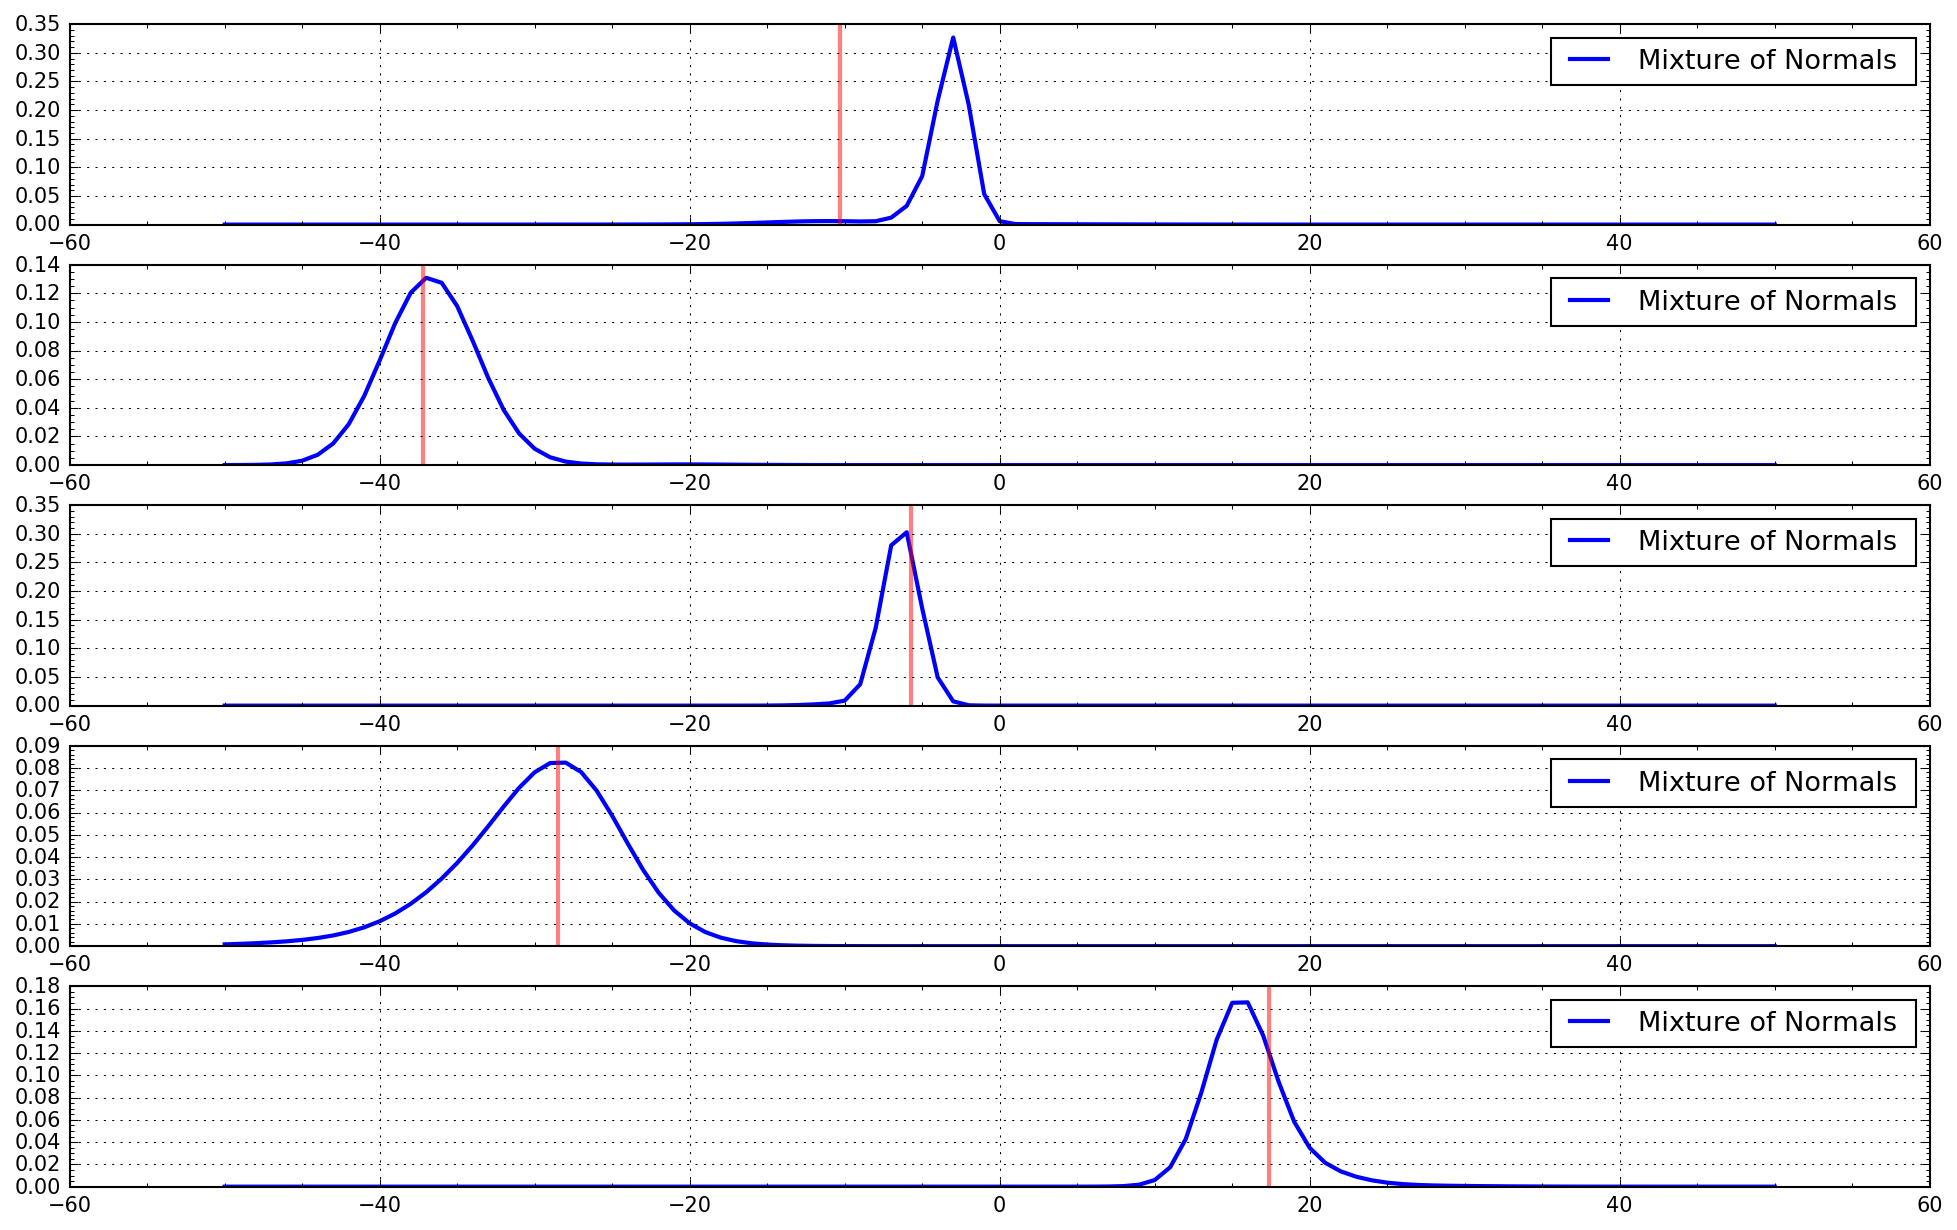

In [44]:
from scipy import stats

def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """
  x = np.linspace(-50, 50, 101)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
      ax.plot(x, temp, label='Normal ' + str(i))
  ax.plot(x, final, label='Mixture of Normals ' + label)
  ax.legend(fontsize=13)

obj = [0, 1, 2, 3, 5]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 10))

for i in xrange(5):
  plot_normal_mix(pred_weights[obj][i], pred_means[obj][i],
                  pred_std[obj][i], axes[i], comp=False)
  axes[i].axvline(x=y_test[0][obj][i], color='r', alpha=0.5)

plt.show()

In [45]:
mdn_results = loaded_model.predict(pu_x_test[:nentries_test], batch_size=2048)
pi     = mdn_results[:,mixture*0:mixture*1]
mus    = mdn_results[:,mixture*1:mixture*2]
sigmas = mdn_results[:,mixture*2:mixture*3]

pred_weights, pred_means, pred_std = pi, mus, sigmas
print(pred_weights.shape, pred_means.shape, pred_std.shape)
for i in range(10):
  #print(pred_weights[i], pred_means[i], pred_std[i])
  tmp = pred_weights[i].argsort()[::-1]
  pred_weights[i] = pred_weights[i][tmp]
  pred_means[i]   = pred_means[i][tmp]
  pred_std[i]     = pred_std[i][tmp]
  #print(pred_weights[i], pred_means[i], pred_std[i])
  mu = np.sum(pred_weights[i] * pred_means[i])
  std = np.sum(pred_weights[i] * (np.square(pred_std[i]) + np.square(pred_means[i] - mu)))
  std = np.sqrt(std)
  print(pu_y_test[0][i], np.sum(pred_weights[i]), mu, std, np.abs(reg_pt_scale/pu_y_test[0][i]), np.abs(reg_pt_scale/mu))

((172244, 6), (172244, 6), (172244, 6))
(100.0, 0.9999999, -37.775105, 7.3493633, 1.0, 2.647246149640541)
(100.0, 1.0, -32.982468, 5.1794357, 1.0, 3.0319138354663044)
(100.0, 1.0, 24.5683, 3.7085133, 1.0, 4.070285652399897)
(100.0, 0.99999994, 29.71082, 10.411484, 1.0, 3.365777267111193)
(100.0, 0.99999994, 29.71082, 10.411484, 1.0, 3.365777267111193)
(100.0, 1.0000001, -11.288538, 19.900848, 1.0, 8.858543080150277)
(100.0, 1.0, 25.05551, 7.2992454, 1.0, 3.9911381459456288)
(100.0, 0.99999994, 5.972496, 18.679207, 1.0, 16.74341840534371)
(100.0, 1.0, 40.770664, 3.9889622, 1.0, 2.452743950219807)
(100.0, 0.99999994, -38.56902, 5.78284, 1.0, 2.5927545415783397)


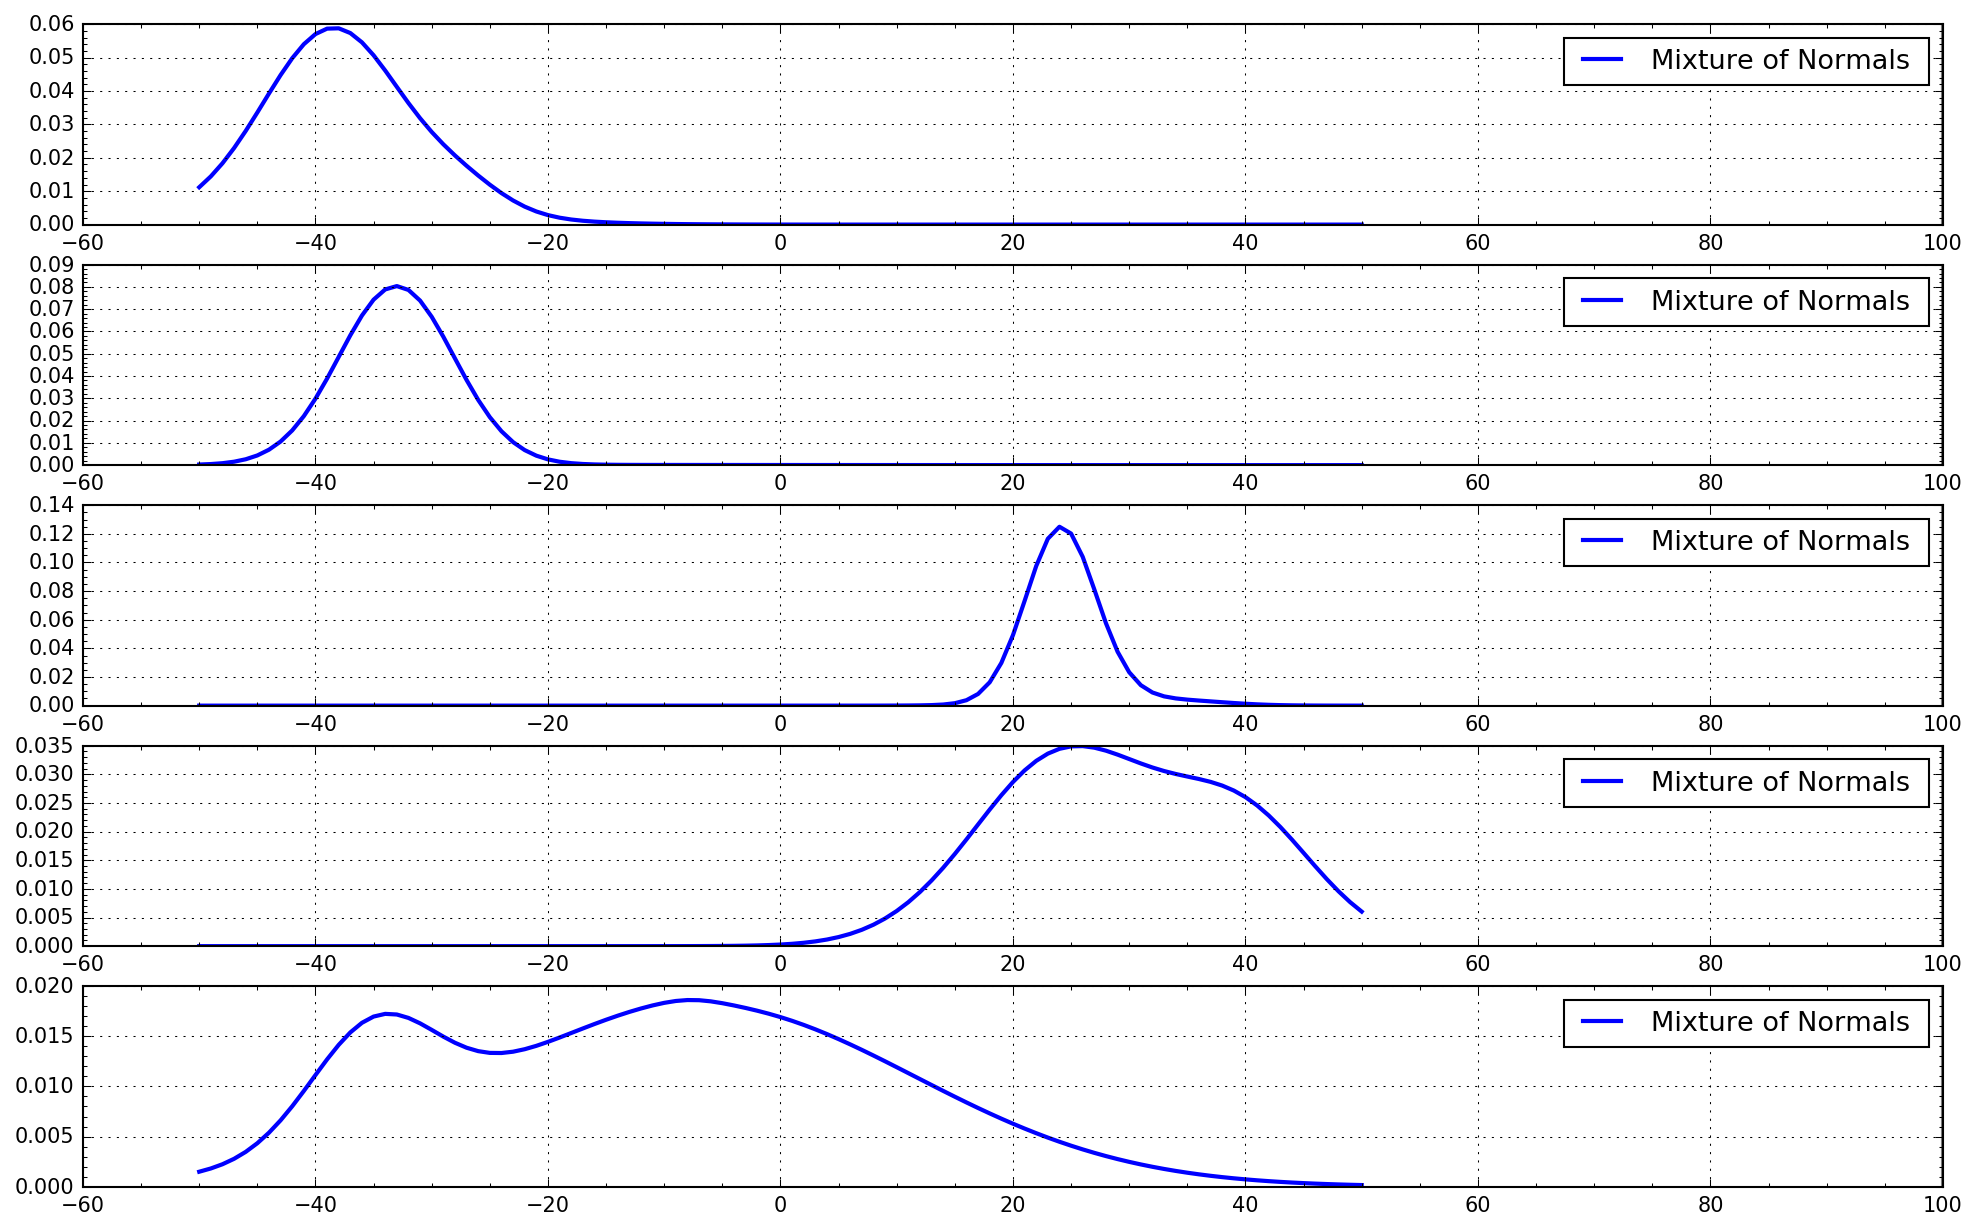

In [46]:
from scipy import stats

def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """
  x = np.linspace(-50, 50, 101)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
      ax.plot(x, temp, label='Normal ' + str(i))
  ax.plot(x, final, label='Mixture of Normals ' + label)
  ax.legend(fontsize=13)

obj = [0, 1, 2, 3, 5]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 10))

for i in xrange(5):
  plot_normal_mix(pred_weights[obj][i], pred_means[obj][i],
                  pred_std[obj][i], axes[i], comp=False)
  axes[i].axvline(x=pu_y_test[0][obj][i], color='r', alpha=0.5)

plt.show()

### Classification Results

### Efficiency & Rates 

In [24]:
# Build a trigger object

pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - abs(ipt - best_ipt)

class MyTrigger(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.7876,  1.5141,  1.5668,  1.8180,  2.1856,  2.6238,  3.1180,  3.6518,
                  4.2080,  4.7782,  5.3612,  5.9617,  6.5794,  7.2110,  7.8532,  8.5003,
                  9.1524,  9.8122, 10.4840, 11.1737, 11.8845, 12.6105, 13.3480, 14.0998,
                 14.8394, 15.5589, 16.2632, 16.9643, 17.6899, 18.4400, 19.2182, 19.9879,
                 20.7742, 21.5960, 22.4655, 23.2708, 23.8952, 24.4560, 25.0216, 25.6357,
                 26.3049, 27.0183, 27.8401, 28.7808, 29.7616, 30.7629, 31.8152, 32.8895,
                 34.0187, 35.0609, 35.9343, 36.7601, 37.6535, 38.5166, 39.3340, 40.2131,
                 41.2479, 42.3861, 43.5010, 44.5325, 45.5142, 46.5268, 47.7044, 48.9894,
                 50.2131, 51.1147, 51.9427, 52.7597, 53.5736, 54.3861, 55.1981, 56.0097,
                 56.8211, 57.6323, 58.4435, 59.2546, 60.0657, 60.8767, 61.6877, 62.4987,
                 63.3096, 64.1206, 64.9315, 65.7425, 66.5534, 67.3643, 68.1752, 68.9862,
                 69.7971, 70.6080, 71.4189, 72.2298, 73.0407, 73.8516, 74.6625, 75.4734,
                 76.2843, 77.0952, 77.9061, 78.7170, 79.5279, 80.3388, 81.1496, 81.9605,
                 82.7714, 83.5823, 84.3932, 85.2041, 86.0150, 86.8259, 87.6368, 88.4477,
                 89.2586, 90.0695, 90.8804, 91.6913, 92.5022, 93.3131, 94.1239, 94.9348]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]

  def get_trigger_pt(self, x, y_meas):
    #zone = int(x[(nlayers*6) + 1] * 6)

    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-8)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return int(binx)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if (binx+1) >= self.s_nbins:  # check boundary
      binx = self.s_nbins-2

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, x, ndof, y_meas, y_discr, discr_pt_cut=14.):
    trk_mode = 0
    x_mode_vars = np.equal(x[nlayers*6+3:nlayers*6+8], 1)
    for i, x_mode_var in enumerate(x_mode_vars):
      if i == 0:
        station = 1
      else:
        station = i
      if x_mode_var:
        trk_mode |= (1 << (4 - station))

    straightness = int(x[(nlayers*6) + 0] * 6) + 6

    ipt1 = straightness
    ipt2 = find_pt_bin(y_meas)
    quality1 = emtf_road_quality(ipt1)
    quality2 = emtf_road_quality(ipt2)

    if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > discr_pt_cut:
        if ndof <= 3:
          #trigger = (y_discr > 0.8)
          trigger = (y_discr > 0.9965)  # 90% coverage
          #trigger = (y_discr > 0.9999)  # 95% coverage
        else:
          #trigger = (y_discr > 0.5393)
          trigger = (y_discr > 0.9670) # 98.5% coverage
          #trigger = (y_discr > 0.9929) # 99% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

mytrigger = MyTrigger()

In [25]:
if False:
  import nn_encode
  reload(nn_encode)
  import nn_data
  reload(nn_data)
  from nn_encode import Encoder
  from nn_data import muon_data_split

  adjust_scale = 0
  reg_pt_scale = 1.0
  correct_for_eta = True
  
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.5, correct_for_eta=correct_for_eta)

  if not isinstance(y_train, list):
    y_train = [y_train]

In [26]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  #print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(84/4, 4, figsize=(4*4,4*84/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i == 80: # dedicated GEM-CSC bend
      lay1, lay2 = 0, 9
      mask = (x_mask_train[...,lay1]) | (x_mask_train[...,lay2])
      mask_fr = (x_train[...,nlayers*5 + lay1])!=0
      mask |= mask_fr
    elif i == 81: # dedicated GEM-CSC bend
      lay1, lay2 = 0, 9
      mask = (x_mask_train[...,lay1]) | (x_mask_train[...,lay2])
      mask_fr = (x_train[...,nlayers*5 + lay1])!=1
      mask |= mask_fr
    elif i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    if adjust_scale == 0:
      _range = None
    else:
      _range = [[xmin, xmax], [ymin, ymax]]
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=_range, cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, x_i.size, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [27]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)
  
  y_train_stdev = np.std(y_train[0]/reg_pt_scale)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i == 80: # dedicated GEM-CSC bend
      lay1, lay2 = 0, 9
      mask = (x_mask_train[...,lay1]) | (x_mask_train[...,lay2])
      mask_fr = (x_train[...,nlayers*5 + lay1])!=0
      mask |= mask_fr
    elif i == 81: # dedicated GEM-CSC bend
      lay1, lay2 = 0, 9
      mask = (x_mask_train[...,lay1]) | (x_mask_train[...,lay2])
      mask_fr = (x_train[...,nlayers*5 + lay1])!=1
      mask |= mask_fr
    elif i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    assert(np.isfinite(x_i).all())
    
    nentries_test = 120000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= y_train_stdev
    #y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1,2,3,4) or lay in (9,10,11,):  # ME1/1, ME1/2, ME2, ME3, ME4, GE1/1, GE2/1, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (5,6):  # RE1, RE2
          coef = 1.0/np.std(x_i)
        else:  # RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # Other
      elif i == 80 or i == 81: # dedicated GEM-CSC bend
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef_tmp = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef_tmp, np.std(x_i), np.std(x_i * coef_tmp), np.std(y_i)
      
      coefs[i] = coef

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [28]:
if False:
  # Check loss functions
  from keras.losses import mean_squared_error, mean_absolute_error
  
  def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)
  
  def asymmetric_huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    x2 = K.abs(y_true) - K.abs(y_pred)  # x2 >= 0: underprediction of 1/pT -> overprediction of pT
    xx = tf.where(tf.logical_or(x < delta, x2 >= 0), squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

  nentries_test = x_test.shape[0]//100

  # Prepare y_test_true, y_test_meas
  y_test_true = y_test
  if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
  y_test_true = y_test_true[:nentries_test].copy()
  y_test_true = y_test_true.reshape(-1)
  #y_test_true /= reg_pt_scale

  y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)
  if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
  y_test_meas = y_test_meas.reshape(-1)
  #y_test_meas /= reg_pt_scale
  
  sess = K.get_session()
  diff = y_test_true - y_test_meas
  mask = np.abs(y_test_true) - np.abs(y_test_meas) > 0.
  
  loss1 = mean_squared_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss2 = mean_absolute_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss3 = huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss4 = asymmetric_huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  
  plt.figure()
  #plt.scatter(diff, loss1, c='r', s=2, edgecolors='none')
  #plt.scatter(diff, loss2, c='g', s=2, edgecolors='none')
  #plt.scatter(diff, loss3, c='b', s=2, edgecolors='none')
  plt.scatter(diff[mask], loss4[mask], c='magenta', s=2, edgecolors='none')
  plt.scatter(diff[~mask], loss4[~mask], c='cyan', s=2, edgecolors='none')
  #plt.legend(['mse', 'mae', 'huber', 'asym huber #1', 'asym huber #2'])
  plt.xlim(-5,5)
  plt.ylim(-1,11)
  plt.show()
  
  print y_test_true.shape, y_test_true, y_test_meas, diff, np.percentile(diff, [25,50,75], overwrite_input=True)

In [29]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()